### Imports

In [7]:
import tensorflow as tf

from keras import Sequential
from keras.applications import vgg16
from keras.optimizers import adam_v2
from keras.losses import sparse_categorical_crossentropy
from keras.layers import Dense, Flatten

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image

### Constants

In [8]:
# Get train and test data from folder.
TRAIN_DIRECTORY = "data/AFD/AFD（Animal Face Dataset)/face images/Saimiri sciureus"
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32  # This is keras default
NUM_CHANNELS = 3
IMAGE_DIMENSIONS = (IMG_HEIGHT, IMG_WIDTH)
SEED = 123

NUM_EPOCHS = 20
LEARNING_RATE = 0.001

VALIDATION_SPLIT = 0.2  # 20% reserved for validation

### Load Data

In [9]:
print("Training:")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIRECTORY,
    validation_split=VALIDATION_SPLIT,
    subset='training',
    seed=SEED,
    image_size=IMAGE_DIMENSIONS,
    batch_size=BATCH_SIZE,
)
print()

print("Validation:")
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIRECTORY,
    validation_split=VALIDATION_SPLIT,
    subset='validation',
    seed=SEED,
    image_size=IMAGE_DIMENSIONS,
    batch_size=BATCH_SIZE,
)

number_classes = len(
    train_ds.class_names) + 2  # 1 for false-positives (not a monkey), 1 for previously unseen individuals

print()
print("Total classes including negative and false-positive:", number_classes)

Training:
Found 252 files belonging to 44 classes.
Using 202 files for training.

Validation:
Found 252 files belonging to 44 classes.
Using 50 files for validation.

Total classes including negative and false-positive: 46


#### Configure the dataset for performance

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

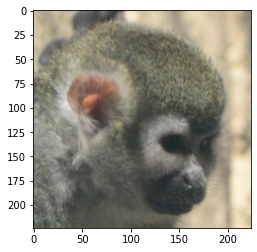

In [11]:
image_batch, labels_batch = next(iter(train_ds))
first_image = image_batch[0]
img = np.array(first_image)
plt.imshow(img / 255)

### Pre-Process Data for VGG

In [12]:
print("Training dataset:", train_ds)

preprocessed_train_ds = train_ds.map(lambda x, y: (vgg16.preprocess_input(x), y))
preprocessed_val_ds = val_ds.map(lambda x, y: (vgg16.preprocess_input(x), y))
image_batch, labels_batch = next(iter(preprocessed_train_ds))
preprocessed_example = image_batch[0]
nd_array = tf.make_ndarray(tf.make_tensor_proto(first_image))
img = Image.fromarray(nd_array, 'RGB')
img.show()

Training dataset: <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>


In [13]:
preprocessed_example.shape

TensorShape([224, 224, 3])

In [14]:
image_batch, labels_batch = next(iter(preprocessed_train_ds))
first_image = image_batch[0]
img = np.array(first_image)

In [15]:
# See here for implementation https://keras.io/api/applications/vgg/#vgg16-function
vgg_model = vgg16.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS),
    pooling='avg',  # Global average pooling applied.
)
# Freeze all layers
vgg_model.trainable = False
fully_connected_output = Sequential()

# Add dense layers to perform prediction
fully_connected_output.add(Flatten())
fully_connected_output.add(Dense(units=4096, activation="relu"))
fully_connected_output.add(Dense(units=4096, activation="relu"))
fully_connected_output.add(Dense(units=number_classes, activation="softmax"))

model = Sequential([vgg_model, fully_connected_output])

In [16]:
optimizer = adam_v2.Adam(learning_rate=LEARNING_RATE)
print("Learning rate:", LEARNING_RATE)

# sparse as Y values are stored as integers (0-42), rather than one-hot encoded (i.e. 3 class, [1,0,0], [0,1,0], [0,0,1])
loss = sparse_categorical_crossentropy

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

Learning rate: 0.001


In [105]:
hist = model.fit(
    x=preprocessed_train_ds,  # y is obtained from this x
    epochs=NUM_EPOCHS,
    verbose=True,
    validation_data=preprocessed_val_ds)

Epoch 1/20
7/7 [==============================] - 16s 2s/step - loss: 23.8859 - accuracy: 0.0644 - val_loss: 14.5440 - val_accuracy: 0.0800
Epoch 2/20
7/7 [==============================] - 16s 2s/step - loss: 6.2247 - accuracy: 0.2574 - val_loss: 3.0939 - val_accuracy: 0.3200
Epoch 3/20
7/7 [==============================] - 16s 2s/step - loss: 2.0815 - accuracy: 0.5644 - val_loss: 2.4213 - val_accuracy: 0.5800
Epoch 4/20
7/7 [==============================] - 16s 2s/step - loss: 0.8704 - accuracy: 0.8218 - val_loss: 1.8536 - val_accuracy: 0.6600
Epoch 5/20
7/7 [==============================] - 16s 2s/step - loss: 0.2923 - accuracy: 0.9455 - val_loss: 1.3567 - val_accuracy: 0.7000
Epoch 6/20
7/7 [==============================] - 16s 2s/step - loss: 0.0879 - accuracy: 0.9851 - val_loss: 0.9830 - val_accuracy: 0.7200
Epoch 7/20
7/7 [==============================] - 16s 2s/step - loss: 0.0352 - accuracy: 0.9950 - val_loss: 1.2117 - val_accuracy: 0.7000
Epoch 8/20
7/7 [================

In [97]:
pp_ex = np.expand_dims(np.array(preprocessed_example), axis=0)

In [100]:
model.predict(pp_ex).shape

(1, 512)

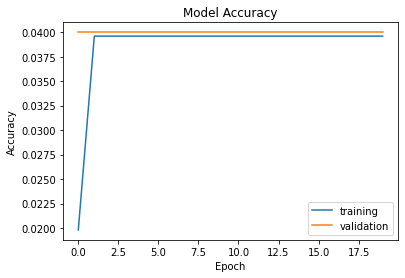

In [41]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["training", "validation"])
plt.show()

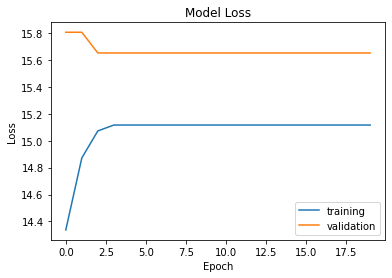

In [42]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["training", "validation"])
plt.show()